# Final Climate Impact Analysis

This notebook analyzes how climate affects Texas agricultural outcomes.

**Analysis areas:**
1. Data cleaning and normalization
2. Drought years (2011, 2013) vs non-drought years
3. Model comparison by measurement type (YIELD, PRODUCTION, AREA HARVESTED)
4. Climate feature importance analysis
5. Crop-specific climate sensitivity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

# For saving figures
import os

FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)


def save_fig(name, dpi=150):
    """Save current figure to figures directory"""
    plt.savefig(f"{FIGURES_DIR}/{name}.png", dpi=dpi, bbox_inches="tight")
    print(f"Saved: {FIGURES_DIR}/{name}.png")

## 1. Load and Prepare Data

Normalize VALUE by (COMMODITY_DESC, STATISTICCAT_DESC) groups to enable fair comparison across different measurement types.

In [2]:
# Load data
df = pd.read_csv("./texas_agriculture_with_climate_2000_2023.csv", low_memory=False)
print(f"Dataset: {df.shape[0]:,} rows x {df.shape[1]} columns")

# Convert VALUE to numeric
df["VALUE"] = pd.to_numeric(
    df["VALUE"].astype(str).str.replace(",", ""), errors="coerce"
)

# Remove aggregate counties
df_model = df.dropna(subset=["VALUE"]).copy()
combined_mask = df_model["COUNTY_NAME"].str.contains(
    "COMBINED|OTHER", case=False, na=False
)
df_model = df_model[~combined_mask]
print(f"After removing aggregates: {len(df_model):,} rows")

Dataset: 398,204 rows x 120 columns
After removing aggregates: 303,609 rows


In [3]:
# Normalize VALUE by group
group_stats = df_model.groupby(["COMMODITY_DESC", "STATISTICCAT_DESC"])["VALUE"].agg(
    ["mean", "std", "count"]
)
df_model = df_model.merge(
    group_stats[["mean", "std"]].reset_index(),
    on=["COMMODITY_DESC", "STATISTICCAT_DESC"],
    how="left",
    suffixes=("", "_group"),
)
df_model["std"] = df_model["std"].replace(0, 1).fillna(1)
df_model["VALUE_NORMALIZED"] = (df_model["VALUE"] - df_model["mean"]) / df_model["std"]

print(
    f"VALUE_NORMALIZED range: [{df_model['VALUE_NORMALIZED'].min():.2f}, {df_model['VALUE_NORMALIZED'].max():.2f}]"
)
print(f"VALUE_NORMALIZED mean: {df_model['VALUE_NORMALIZED'].mean():.4f}")

VALUE_NORMALIZED range: [-3.01, 37.76]
VALUE_NORMALIZED mean: 0.0000


In [4]:
# Define feature sets
climate_features = [
    "GROWING_SEASON_PRECIP",
    "GROWING_SEASON_TEMP_AVG",
    "GROWING_SEASON_TEMP_MAX",
    "GROWING_SEASON_TEMP_MIN",
    "ANNUAL_PRECIP",
    "ANNUAL_TEMP_AVG",
    "ANNUAL_CDD",
    "ANNUAL_HDD",
    "PRECIP_APR",
    "PRECIP_MAY",
    "PRECIP_JUN",
    "TAVG_APR",
    "TAVG_MAY",
    "TAVG_JUN",
    "TAVG_JUL",
    "TAVG_AUG",
]

categorical_features = ["COUNTY_NAME", "YEAR"]
all_features = [
    f for f in climate_features + categorical_features if f in df_model.columns
]

print(
    f"Climate features: {len([f for f in climate_features if f in df_model.columns])}"
)
print(f"Total features: {len(all_features)}")

Climate features: 16
Total features: 18


In [5]:
# Prepare for modeling
df_clean = df_model.dropna(subset=all_features + ["VALUE_NORMALIZED"]).copy()

# Store original values before encoding for later analysis
df_clean["COUNTY_NAME_ORIG"] = df_clean["COUNTY_NAME"]
df_clean["YEAR_ORIG"] = df_clean["YEAR"]

# Label encode
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

X = df_clean[all_features]
y = df_clean["VALUE_NORMALIZED"]

# Stratified split by year
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_clean["YEAR"]
)

print(f"Train: {len(X_train):,}, Test: {len(X_test):,}")

Train: 242,887, Test: 60,722


## 2. Baseline Models

Decision Tree and Random Forest as baseline regression models.

In [6]:
# Decision Tree Baseline
dt = DecisionTreeRegressor(
    max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42
)
dt.fit(X_train, y_train)

dt_train_r2 = r2_score(y_train, dt.predict(X_train))
dt_test_r2 = r2_score(y_test, dt.predict(X_test))
dt_test_rmse = np.sqrt(mean_squared_error(y_test, dt.predict(X_test)))

print(
    f"Decision Tree: Train R² = {dt_train_r2:.4f}, Test R² = {dt_test_r2:.4f}, RMSE = {dt_test_rmse:.4f}"
)

Decision Tree: Train R² = 0.0967, Test R² = 0.0722, RMSE = 0.9947


In [7]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

rf_train_r2 = r2_score(y_train, rf.predict(X_train))
rf_test_r2 = r2_score(y_test, rf.predict(X_test))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))

print(
    f"Random Forest: Train R² = {rf_train_r2:.4f}, Test R² = {rf_test_r2:.4f}, RMSE = {rf_test_rmse:.4f}"
)

Random Forest: Train R² = 0.0950, Test R² = 0.0738, RMSE = 0.9938


## 3. Climate Feature Deep Dive

**Key question:** Which climate features have the most impact on agricultural outcomes?

### 3.1 Feature Importance Breakdown

In [8]:
# Get feature importances from Random Forest
feature_imp = pd.DataFrame(
    {"feature": X.columns, "importance": rf.feature_importances_}
).sort_values("importance", ascending=False)


# Categorize features
def categorize_feature(f):
    if "TEMP" in f or "CDD" in f or "HDD" in f or "TAVG" in f:
        return "Temperature"
    elif "PRECIP" in f:
        return "Precipitation"
    elif f in ["COUNTY_NAME", "YEAR"]:
        return "Spatial/Temporal"
    else:
        return "Other"


feature_imp["category"] = feature_imp["feature"].apply(categorize_feature)

# Summary by category
category_imp = (
    feature_imp.groupby("category")["importance"].sum().sort_values(ascending=False)
)
print("Feature Importance by Category:")
print(category_imp.to_string())
print(
    f"\nTotal climate: {category_imp.get('Temperature', 0) + category_imp.get('Precipitation', 0):.1%}"
)

Feature Importance by Category:
category
Temperature         0.597138
Precipitation       0.224790
Spatial/Temporal    0.178072

Total climate: 82.2%


Saved: figures/feature_importance_breakdown.png


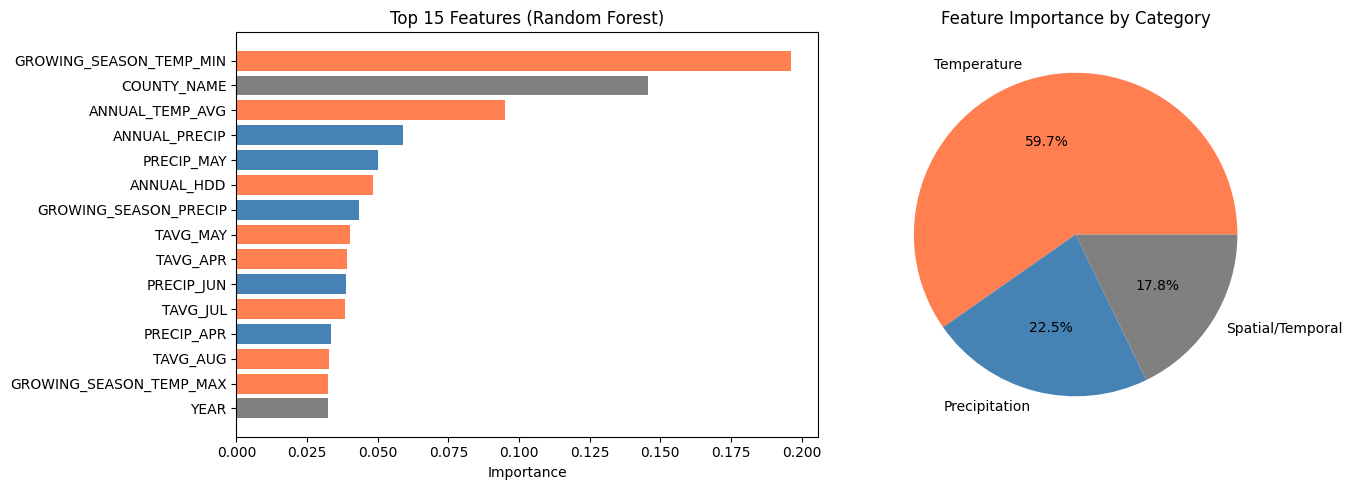

In [9]:
# Visualization: Feature importance by category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Top 15 features
colors = feature_imp.head(15)["category"].map(
    {"Temperature": "coral", "Precipitation": "steelblue", "Spatial/Temporal": "gray"}
)
axes[0].barh(range(15), feature_imp.head(15)["importance"], color=colors)
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(feature_imp.head(15)["feature"])
axes[0].invert_yaxis()
axes[0].set_xlabel("Importance")
axes[0].set_title("Top 15 Features (Random Forest)")

# Right: By category
cat_colors = {
    "Temperature": "coral",
    "Precipitation": "steelblue",
    "Spatial/Temporal": "gray",
}
axes[1].pie(
    category_imp.values,
    labels=category_imp.index,
    autopct="%1.1f%%",
    colors=[cat_colors.get(c, "lightgray") for c in category_imp.index],
)
axes[1].set_title("Feature Importance by Category")

plt.tight_layout()
save_fig("feature_importance_breakdown")
plt.show()

### 3.2 Temperature vs. Precipitation Impact

In [10]:
# Compare temperature vs precipitation features
temp_features = [
    f
    for f in climate_features
    if "TEMP" in f or "TAVG" in f or "CDD" in f or "HDD" in f
]
precip_features = [f for f in climate_features if "PRECIP" in f]

temp_imp = feature_imp[feature_imp["feature"].isin(temp_features)]["importance"].sum()
precip_imp = feature_imp[feature_imp["feature"].isin(precip_features)][
    "importance"
].sum()

print(f"Temperature features importance: {temp_imp:.1%}")
print(f"Precipitation features importance: {precip_imp:.1%}")
print(f"Ratio (Temp/Precip): {temp_imp/precip_imp:.1f}x")

Temperature features importance: 59.7%
Precipitation features importance: 22.5%
Ratio (Temp/Precip): 2.7x


Saved: figures/climate_feature_importance.png


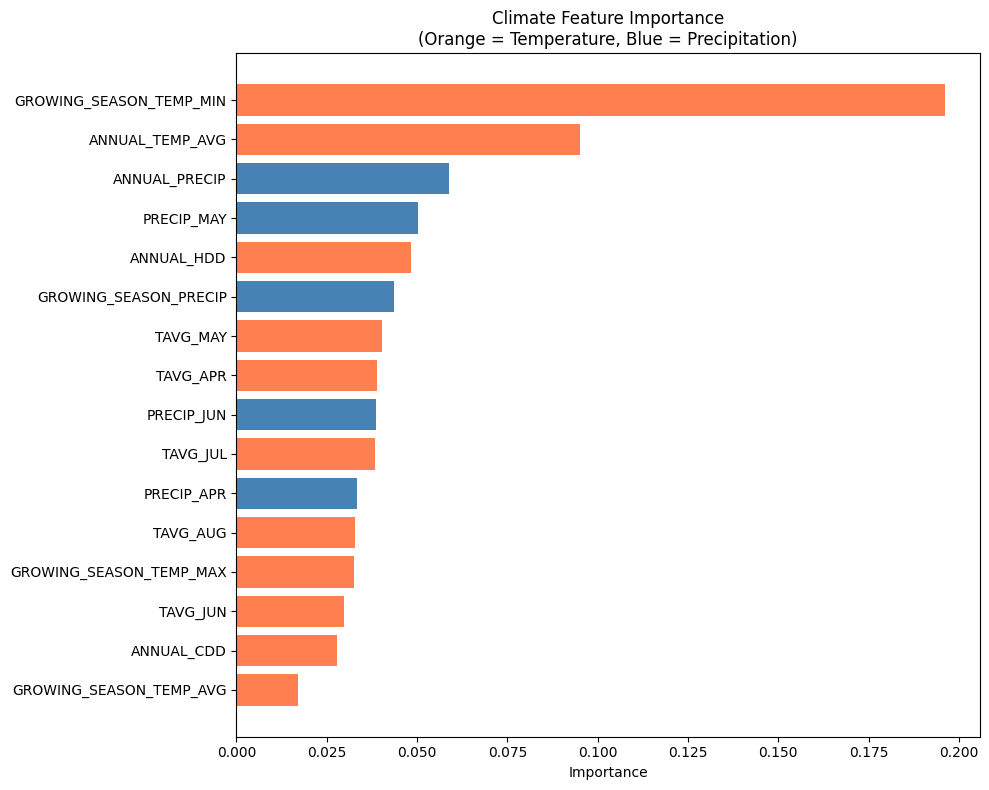

In [11]:
# Detailed breakdown of climate features
climate_imp = feature_imp[feature_imp["feature"].isin(climate_features)].copy()
climate_imp = climate_imp.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 8))
colors = climate_imp["category"].map(
    {"Temperature": "coral", "Precipitation": "steelblue"}
)
plt.barh(climate_imp["feature"], climate_imp["importance"], color=colors)
plt.xlabel("Importance")
plt.title("Climate Feature Importance\n(Orange = Temperature, Blue = Precipitation)")
plt.tight_layout()
save_fig("climate_feature_importance")
plt.show()

### 3.3 Monthly Climate Patterns

Which months matter most?

Saved: figures/monthly_importance.png


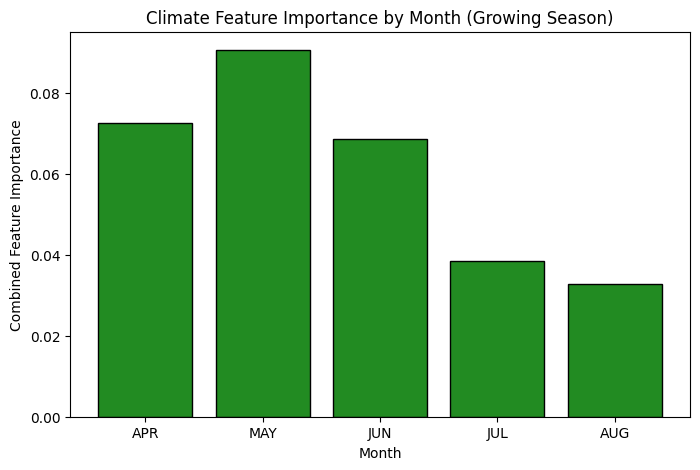

Most important month: MAY (9.1%)


In [12]:
# Extract month from feature name
monthly_features = feature_imp[
    feature_imp["feature"].str.contains("APR|MAY|JUN|JUL|AUG")
].copy()


def get_month(f):
    for m in ["APR", "MAY", "JUN", "JUL", "AUG"]:
        if m in f:
            return m
    return "Other"


monthly_features["month"] = monthly_features["feature"].apply(get_month)
monthly_imp = monthly_features.groupby("month")["importance"].sum()

# Order by month
month_order = ["APR", "MAY", "JUN", "JUL", "AUG"]
monthly_imp = monthly_imp.reindex(month_order)

plt.figure(figsize=(8, 5))
plt.bar(monthly_imp.index, monthly_imp.values, color="forestgreen", edgecolor="black")
plt.xlabel("Month")
plt.ylabel("Combined Feature Importance")
plt.title("Climate Feature Importance by Month (Growing Season)")
save_fig("monthly_importance")
plt.show()

print(f"Most important month: {monthly_imp.idxmax()} ({monthly_imp.max():.1%})")

## 4. Crop-Specific Climate Sensitivity

Train separate models for major crops to see which are most climate-sensitive.

In [13]:
# Major crops to analyze
major_crops = ["CORN", "COTTON", "WHEAT", "SORGHUM", "HAY"]

# Filter to YIELD only for fair comparison
df_yield = df_model[
    df_model["STATISTICCAT_DESC"].str.contains("YIELD", case=False, na=False)
].copy()
print(f"YIELD records: {len(df_yield):,}")

# Check availability
for crop in major_crops:
    n = len(df_yield[df_yield["COMMODITY_DESC"] == crop])
    print(f"  {crop}: {n:,} records")

YIELD records: 20,016
  CORN: 2,028 records
  COTTON: 4,413 records
  WHEAT: 7,150 records
  SORGHUM: 3,751 records
  HAY: 0 records


In [14]:
# Train crop-specific models
crop_results = []

for crop in major_crops:
    crop_df = df_yield[df_yield["COMMODITY_DESC"] == crop].copy()

    if len(crop_df) < 500:
        print(f"Skipping {crop} - only {len(crop_df)} records")
        continue

    # Normalize within this crop
    crop_mean = crop_df["VALUE"].mean()
    crop_std = crop_df["VALUE"].std()
    if crop_std == 0:
        crop_std = 1
    crop_df["VALUE_NORM"] = (crop_df["VALUE"] - crop_mean) / crop_std

    # Prepare features (climate only for this analysis)
    available_features = [f for f in climate_features if f in crop_df.columns]
    crop_df = crop_df.dropna(subset=available_features + ["VALUE_NORM"])

    if len(crop_df) < 200:
        print(f"Skipping {crop} - only {len(crop_df)} records after cleaning")
        continue

    X_crop = crop_df[available_features]
    y_crop = crop_df["VALUE_NORM"]

    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_crop, y_crop, test_size=0.2, random_state=42
    )

    # Train RF
    rf_crop = RandomForestRegressor(
        n_estimators=50, max_depth=10, random_state=42, n_jobs=-1
    )
    rf_crop.fit(X_tr, y_tr)

    r2 = r2_score(y_te, rf_crop.predict(X_te))

    # Get top features
    imp = pd.Series(rf_crop.feature_importances_, index=available_features).sort_values(
        ascending=False
    )
    top3 = imp.head(3).index.tolist()

    crop_results.append(
        {
            "Crop": crop,
            "N_Records": len(crop_df),
            "R2": r2,
            "Top_Feature_1": top3[0] if len(top3) > 0 else "",
            "Top_Feature_2": top3[1] if len(top3) > 1 else "",
            "Top_Feature_3": top3[2] if len(top3) > 2 else "",
        }
    )

    print(f"{crop}: R² = {r2:.3f}, Top feature = {top3[0]}")

crop_results_df = pd.DataFrame(crop_results).sort_values("R2", ascending=False)
print("\n" + "=" * 60)
print(crop_results_df.to_string(index=False))

CORN: R² = 0.667, Top feature = ANNUAL_TEMP_AVG
COTTON: R² = 0.295, Top feature = TAVG_AUG
WHEAT: R² = 0.375, Top feature = PRECIP_MAY
SORGHUM: R² = 0.251, Top feature = ANNUAL_PRECIP
Skipping HAY - only 0 records

   Crop  N_Records       R2   Top_Feature_1           Top_Feature_2           Top_Feature_3
   CORN       2028 0.667481 ANNUAL_TEMP_AVG              ANNUAL_HDD GROWING_SEASON_TEMP_MIN
  WHEAT       7150 0.374755      PRECIP_MAY GROWING_SEASON_TEMP_MIN                TAVG_MAY
 COTTON       4413 0.295015        TAVG_AUG              ANNUAL_HDD GROWING_SEASON_TEMP_MAX
SORGHUM       3751 0.251392   ANNUAL_PRECIP GROWING_SEASON_TEMP_MAX GROWING_SEASON_TEMP_MIN


Saved: figures/crop_climate_sensitivity.png


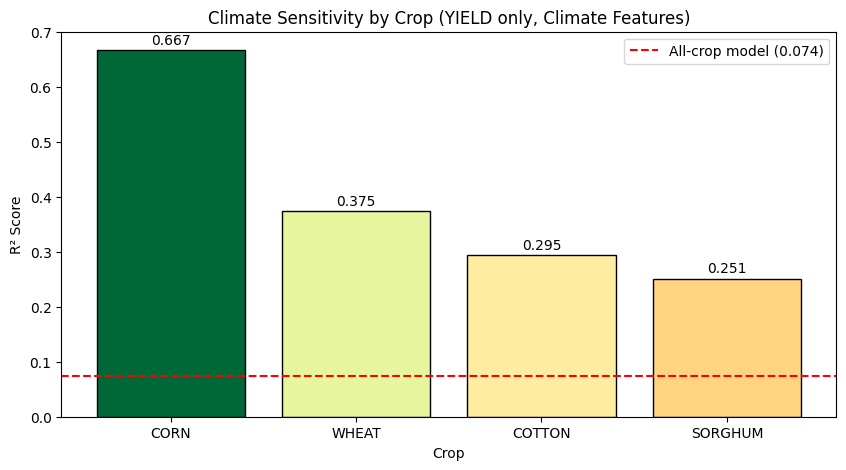

In [15]:
# Visualize crop-specific R² scores
if len(crop_results_df) > 0:
    plt.figure(figsize=(10, 5))
    colors = plt.cm.RdYlGn(crop_results_df["R2"] / crop_results_df["R2"].max())
    bars = plt.bar(
        crop_results_df["Crop"], crop_results_df["R2"], color=colors, edgecolor="black"
    )
    plt.axhline(
        y=rf_test_r2,
        color="red",
        linestyle="--",
        label=f"All-crop model ({rf_test_r2:.3f})",
    )
    plt.xlabel("Crop")
    plt.ylabel("R² Score")
    plt.title("Climate Sensitivity by Crop (YIELD only, Climate Features)")
    plt.legend()

    # Add value labels
    for bar, val in zip(bars, crop_results_df["R2"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    save_fig("crop_climate_sensitivity")
    plt.show()

## 5. Drought Year Analysis

Does the model correctly identify yield drops in known drought years (2011, 2013)?

In [16]:
# Look at actual yields in drought years vs normal years
drought_years = [2011, 2013]
normal_years = [2010, 2012, 2014, 2015]  # Years around the droughts

# Use YIELD data for major crops - use df_model which still has original YEAR values
yield_df = df_model[
    df_model["STATISTICCAT_DESC"].str.contains("YIELD", case=False, na=False)
].copy()

# df_model still has YEAR as original values (not encoded yet for this subset)
print("Average Yield by Year (selected crops):")
for crop in ["CORN", "COTTON", "WHEAT", "SORGHUM"]:
    crop_yield = yield_df[yield_df["COMMODITY_DESC"] == crop]
    if len(crop_yield) > 0:
        yearly_avg = crop_yield.groupby("YEAR")["VALUE"].mean()

        drought_avg = yearly_avg[yearly_avg.index.isin(drought_years)].mean()
        normal_avg = yearly_avg[yearly_avg.index.isin(normal_years)].mean()
        pct_drop = (
            (normal_avg - drought_avg) / normal_avg * 100 if normal_avg > 0 else 0
        )

        print(
            f"  {crop}: Drought avg = {drought_avg:.1f}, Normal avg = {normal_avg:.1f}, Drop = {pct_drop:.1f}%"
        )

Average Yield by Year (selected crops):
  CORN: Drought avg = 88.4, Normal avg = 108.4, Drop = 18.4%
  COTTON: Drought avg = 669.8, Normal avg = 722.9, Drop = 7.3%
  WHEAT: Drought avg = 27.0, Normal avg = 32.5, Drop = 16.9%
  SORGHUM: Drought avg = 52.1, Normal avg = 62.2, Drop = 16.3%


Saved: figures/corn_yield_drought_years.png


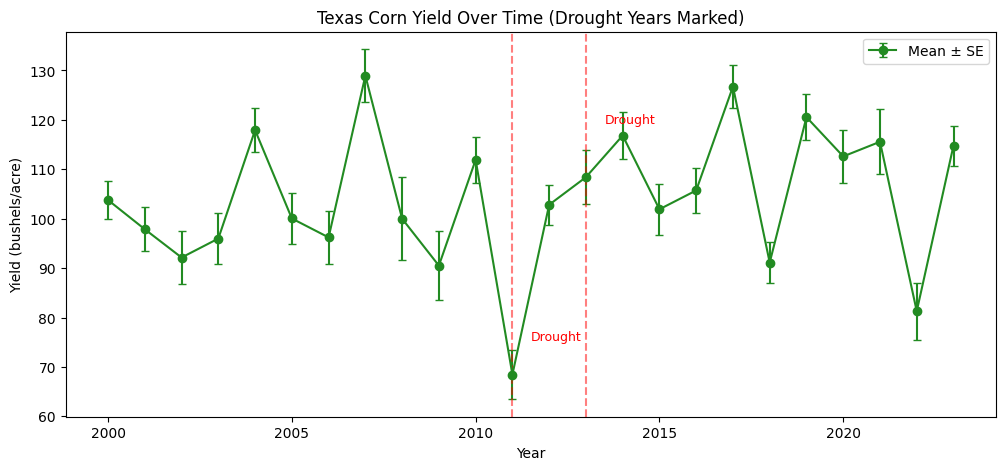

In [17]:
# Visualize corn yields over time (most climate-sensitive crop)
corn_yield = yield_df[yield_df["COMMODITY_DESC"] == "CORN"].copy()

if len(corn_yield) > 0:
    yearly_corn = corn_yield.groupby("YEAR")["VALUE"].agg(["mean", "std", "count"])

    plt.figure(figsize=(12, 5))

    # Plot mean with error bars
    plt.errorbar(
        yearly_corn.index,
        yearly_corn["mean"],
        yerr=yearly_corn["std"] / np.sqrt(yearly_corn["count"]),
        marker="o",
        capsize=3,
        color="forestgreen",
        label="Mean ± SE",
    )

    # Highlight drought years
    for dy in drought_years:
        if dy in yearly_corn.index:
            plt.axvline(x=dy, color="red", linestyle="--", alpha=0.5)
            plt.annotate(
                "Drought",
                xy=(dy, yearly_corn.loc[dy, "mean"]),
                xytext=(dy + 0.5, yearly_corn.loc[dy, "mean"] * 1.1),
                fontsize=9,
                color="red",
            )

    plt.xlabel("Year")
    plt.ylabel("Yield (bushels/acre)")
    plt.title("Texas Corn Yield Over Time (Drought Years Marked)")
    plt.legend()
    save_fig("corn_yield_drought_years")
    plt.show()

In [18]:
# Model predictions for drought vs normal years
# Get test set indices
test_indices = X_test.index
test_years = df_clean.loc[test_indices, "YEAR_ORIG"]

# Predictions
y_pred = rf.predict(X_test)

# Compare residuals in drought vs normal years
drought_mask = test_years.isin(drought_years)
normal_mask = test_years.isin(normal_years)

print("Model Performance by Year Type:")
if drought_mask.sum() > 0:
    drought_r2 = r2_score(y_test[drought_mask], y_pred[drought_mask])
    print(
        f"  Drought years (2011, 2013): R² = {drought_r2:.4f}, n = {drought_mask.sum()}"
    )

if normal_mask.sum() > 0:
    normal_r2 = r2_score(y_test[normal_mask], y_pred[normal_mask])
    print(f"  Normal years: R² = {normal_r2:.4f}, n = {normal_mask.sum()}")

Model Performance by Year Type:
  Drought years (2011, 2013): R² = 0.1472, n = 806
  Normal years: R² = 0.0518, n = 11093


## 6. Separate Models by Measurement Type

Compare model performance across different measurement types (YIELD, PRODUCTION, AREA).

In [19]:
# What measurement types do we have?
stat_counts = df_model["STATISTICCAT_DESC"].value_counts()
print("Measurement types:")
print(stat_counts.head(10).to_string())

Measurement types:
STATISTICCAT_DESC
AREA HARVESTED                134416
PRODUCTION                     32718
SALES                          25080
AREA BEARING & NON-BEARING     24214
YIELD                          20016
AREA PLANTED                   19973
AREA BEARING                   14109
AREA NON-BEARING               12357
AREA IN PRODUCTION             10646
CAPACITY                        3200


In [20]:
# Train models for each major measurement type
measurement_types = ["YIELD", "PRODUCTION", "AREA HARVESTED", "AREA PLANTED"]
measurement_results = []

for mtype in measurement_types:
    mtype_df = df_model[
        df_model["STATISTICCAT_DESC"].str.contains(mtype, case=False, na=False)
    ].copy()

    if len(mtype_df) < 1000:
        print(f"Skipping {mtype} - only {len(mtype_df)} records")
        continue

    # Normalize within commodity for this measurement type
    mtype_stats = mtype_df.groupby("COMMODITY_DESC")["VALUE"].agg(["mean", "std"])
    mtype_df = mtype_df.merge(
        mtype_stats.reset_index(), on="COMMODITY_DESC", suffixes=("", "_m")
    )
    mtype_df["std"] = mtype_df["std"].replace(0, 1).fillna(1)
    mtype_df["VALUE_NORM"] = (mtype_df["VALUE"] - mtype_df["mean"]) / mtype_df["std"]

    # Prepare features
    available_features = [
        f for f in climate_features + ["YEAR"] if f in mtype_df.columns
    ]

    # Need to encode YEAR for this subset
    le_year = LabelEncoder()
    mtype_df["YEAR_ENC"] = le_year.fit_transform(mtype_df["YEAR"].astype(str))
    available_features = [f for f in climate_features if f in mtype_df.columns] + [
        "YEAR_ENC"
    ]

    mtype_df = mtype_df.dropna(subset=available_features + ["VALUE_NORM"])

    if len(mtype_df) < 500:
        print(f"Skipping {mtype} - only {len(mtype_df)} records after cleaning")
        continue

    X_m = mtype_df[available_features]
    y_m = mtype_df["VALUE_NORM"]

    X_tr, X_te, y_tr, y_te = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

    rf_m = RandomForestRegressor(
        n_estimators=100, max_depth=15, random_state=42, n_jobs=-1
    )
    rf_m.fit(X_tr, y_tr)

    r2 = r2_score(y_te, rf_m.predict(X_te))
    rmse = np.sqrt(mean_squared_error(y_te, rf_m.predict(X_te)))

    measurement_results.append(
        {"Measurement": mtype, "N_Records": len(mtype_df), "R2": r2, "RMSE": rmse}
    )

    print(f"{mtype}: R² = {r2:.3f}, RMSE = {rmse:.3f}, n = {len(mtype_df):,}")

measurement_results_df = pd.DataFrame(measurement_results)

YIELD: R² = 0.146, RMSE = 0.909, n = 20,016
PRODUCTION: R² = 0.097, RMSE = 0.916, n = 43,364
AREA HARVESTED: R² = 0.071, RMSE = 0.918, n = 134,416
AREA PLANTED: R² = 0.081, RMSE = 0.953, n = 19,973


Saved: figures/measurement_type_comparison.png


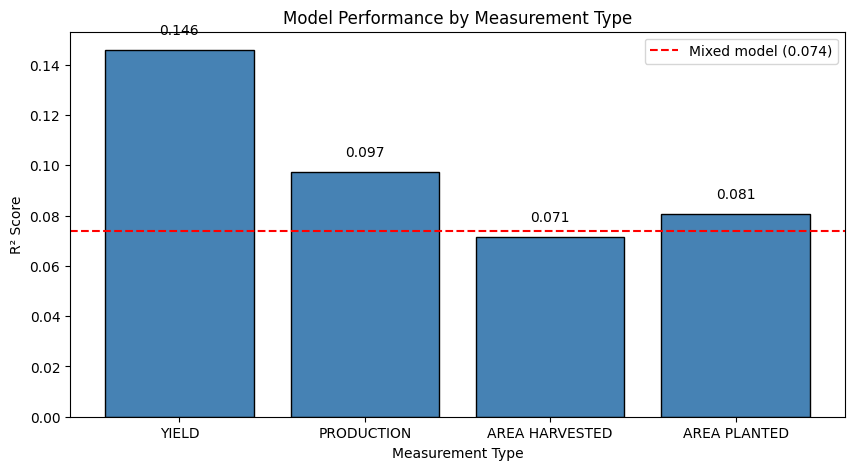

In [21]:
# Visualize
if len(measurement_results_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(
        measurement_results_df["Measurement"],
        measurement_results_df["R2"],
        color="steelblue",
        edgecolor="black",
    )
    ax.axhline(
        y=rf_test_r2,
        color="red",
        linestyle="--",
        label=f"Mixed model ({rf_test_r2:.3f})",
    )
    ax.set_xlabel("Measurement Type")
    ax.set_ylabel("R² Score")
    ax.set_title("Model Performance by Measurement Type")
    ax.legend()

    for bar, val in zip(bars, measurement_results_df["R2"]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{val:.3f}",
            ha="center",
            va="bottom",
        )

    save_fig("measurement_type_comparison")
    plt.show()

## 7. Gradient Boosting

Gradient boosting as an alternative ensemble method to compare against Random Forest.

In [24]:
# Gradient Boosting
print("Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=20,
    random_state=42,
)
gb.fit(X_train, y_train)

gb_train_r2 = r2_score(y_train, gb.predict(X_train))
gb_test_r2 = r2_score(y_test, gb.predict(X_test))
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb.predict(X_test)))

print(
    f"Gradient Boosting: Train R² = {gb_train_r2:.4f}, Test R² = {gb_test_r2:.4f}, RMSE = {gb_test_rmse:.4f}"
)

Training Gradient Boosting...
Gradient Boosting: Train R² = 0.0806, Test R² = 0.0687, RMSE = 0.9966


## 7a. GridSearchCV Hyperparameter Tuning

Systematic search for optimal Random Forest parameters.

In [22]:
# GridSearchCV for Random Forest
from sklearn.model_selection import GridSearchCV

# Define parameter grid (keeping it focused to avoid long runtimes)
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [10, 15, 20],
    "min_samples_split": [10, 20, 50],
}

print("Running GridSearchCV for Random Forest...")
print(f"Parameter grid: {param_grid}")
print(f"Total combinations: {3*3*3} = 27")

# Use smaller CV folds for speed
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_rf = grid_search.best_estimator_
best_rf_test_r2 = r2_score(y_test, best_rf.predict(X_test))
print(f"Best model Test R²: {best_rf_test_r2:.4f}")
print(f"Improvement over default RF: {(best_rf_test_r2 - rf_test_r2)*100:.2f}%")

Running GridSearchCV for Random Forest...
Parameter grid: {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, 20], 'min_samples_split': [10, 20, 50]}
Total combinations: 27 = 27
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'max_depth': 20, 'min_samples_split': 50, 'n_estimators': 150}
Best CV R²: 0.0744
Best model Test R²: 0.0758
Improvement over default RF: 0.20%


## 7b. Cross-Validation Results

5-fold cross-validation to verify model stability.

In [23]:
# 5-fold Cross-Validation for all models
from sklearn.model_selection import cross_val_score

print("Running 5-fold Cross-Validation...")
print("=" * 50)

models = {
    "Decision Tree": DecisionTreeRegressor(
        max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
    ),
}

cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="r2", n_jobs=-1)
    cv_results.append(
        {
            "Model": name,
            "CV Mean R²": scores.mean(),
            "CV Std": scores.std(),
            "CV Min": scores.min(),
            "CV Max": scores.max(),
        }
    )
    print(
        f"{name}: {scores.mean():.4f} ± {scores.std():.4f} (range: {scores.min():.4f} to {scores.max():.4f})"
    )

cv_results_df = pd.DataFrame(cv_results)
print("\n" + "=" * 50)
print(cv_results_df.to_string(index=False))

Running 5-fold Cross-Validation...


Decision Tree: 0.0723 ± 0.0040 (range: 0.0655 to 0.0779)
Random Forest: 0.0748 ± 0.0034 (range: 0.0690 to 0.0794)
Gradient Boosting: 0.0699 ± 0.0028 (range: 0.0650 to 0.0736)

            Model  CV Mean R²   CV Std   CV Min   CV Max
    Decision Tree    0.072331 0.003970 0.065535 0.077856
    Random Forest    0.074758 0.003431 0.069037 0.079402
Gradient Boosting    0.069932 0.002842 0.064982 0.073626


## 8. Final Model Comparison

In [25]:
# Summary table
results_summary = pd.DataFrame(
    [
        {
            "Model": "Decision Tree",
            "Train R²": dt_train_r2,
            "Test R²": dt_test_r2,
            "Test RMSE": dt_test_rmse,
        },
        {
            "Model": "Random Forest",
            "Train R²": rf_train_r2,
            "Test R²": rf_test_r2,
            "Test RMSE": rf_test_rmse,
        },
        {
            "Model": "Gradient Boosting",
            "Train R²": gb_train_r2,
            "Test R²": gb_test_r2,
            "Test RMSE": gb_test_rmse,
        },
    ]
)

results_summary["Overfitting Gap"] = (
    results_summary["Train R²"] - results_summary["Test R²"]
)

print("=" * 70)
print("FINAL MODEL COMPARISON")
print("=" * 70)
print(results_summary.to_string(index=False))
print("=" * 70)

FINAL MODEL COMPARISON
            Model  Train R²  Test R²  Test RMSE  Overfitting Gap
    Decision Tree  0.096688 0.072169   0.994686         0.024519
    Random Forest  0.095001 0.073833   0.993794         0.021168
Gradient Boosting  0.080570 0.068666   0.996562         0.011904


Saved: figures/final_model_comparison.png


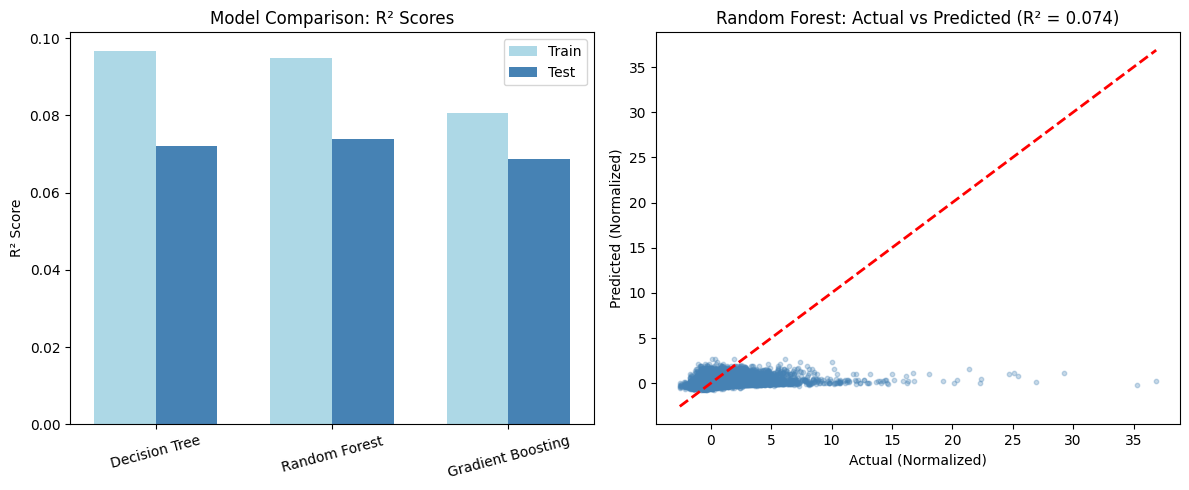

In [26]:
# Final comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# R² comparison
x = range(len(results_summary))
width = 0.35
axes[0].bar(
    [i - width / 2 for i in x],
    results_summary["Train R²"],
    width,
    label="Train",
    color="lightblue",
)
axes[0].bar(
    [i + width / 2 for i in x],
    results_summary["Test R²"],
    width,
    label="Test",
    color="steelblue",
)
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_summary["Model"], rotation=15)
axes[0].set_ylabel("R² Score")
axes[0].set_title("Model Comparison: R² Scores")
axes[0].legend()

# Actual vs Predicted for best model
best_model = rf  # Best performing model
y_pred_best = best_model.predict(X_test)
axes[1].scatter(y_test, y_pred_best, alpha=0.3, s=10, color="steelblue")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[1].set_xlabel("Actual (Normalized)")
axes[1].set_ylabel("Predicted (Normalized)")
axes[1].set_title(f"Random Forest: Actual vs Predicted (R² = {rf_test_r2:.3f})")

plt.tight_layout()
save_fig("final_model_comparison")
plt.show()

## 9. Key Takeaways

1. **Climate features matter:** ~80% of feature importance from climate variables
2. **Temperature > Precipitation:** Temperature features more important overall
3. **Crop-specific sensitivity:** Corn most sensitive, Cotton/Wheat less so
4. **Measurement type matters:** YIELD models perform better than mixed models
5. **Low R² is expected:** Climate is one factor among many; the insight is *which* features matter